In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
data = pd.read_csv('data/PLD.csv')
data

,Unnamed: 0,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,...,returnOnTangibleAssets,revenuePerShare,roe,roic,salesGeneralAndAdministrativeToRevenue,shareholdersEquityPerShare,stockBasedCompensationToRevenue,tangibleAssetValue,tangibleBookValuePerShare,workingCapital
0,21,2023-12-29,134.08,135.04,133.07,133.30,133.30,2938090,2938090,-0.78,...,0.006783,1.983672,0.011864,0.006577,0.050491,55.839752,-0.657998,5.782372e+10,60.713755,-530519000.0
1,22,2023-12-28,134.10,135.22,133.48,135.19,135.19,1953285,1953285,1.09,...,0.006783,1.983672,0.011864,0.006577,0.050491,55.839752,-0.657998,5.782372e+10,60.713755,-530519000.0
2,23,2023-12-27,133.86,134.19,132.78,134.18,134.18,2714750,2714750,0.32,...,0.006783,1.983672,0.011864,0.006577,0.050491,55.839752,-0.657998,5.782372e+10,60.713755,-530519000.0
3,24,2023-12-26,132.46,133.88,132.46,133.46,133.46,1215992,1215992,1.00,...,0.006783,1.983672,0.011864,0.006577,0.050491,55.839752,-0.657998,5.782372e+10,60.713755,-530519000.0
4,25,2023-12-22,131.07,133.22,130.81,132.40,132.40,2361335,2361335,1.33,...,0.006783,1.983672,0.011864,0.006577,0.050491,55.839752,-0.657998,5.782372e+10,60.713755,-530519000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,6286,1999-02-05,21.94,21.94,21.75,21.81,8.17,29500,29500,-0.13,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0
6266,6287,1999-02-04,21.94,22.00,21.88,21.94,8.22,100600,100600,-0.13,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0
6267,6288,1999-02-03,22.06,22.06,21.94,22.00,8.24,33400,33400,-0.06,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0
6268,6289,1999-02-02,21.94,22.06,21.94,22.06,8.26,80600,80600,0.12,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0


In [3]:
data.rename(columns={'date':'Date','close':'Close'},inplace=True)
data = data[['Date','Close']]
data

,Date,Close
0,2023-12-29,133.30
1,2023-12-28,135.19
2,2023-12-27,134.18
3,2023-12-26,133.46
4,2023-12-22,132.40
...,...,...
6265,1999-02-05,21.81
6266,1999-02-04,21.94
6267,1999-02-03,22.00
6268,1999-02-02,22.06


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

/var/folders/f5/msl9m0cs5nxb47jjzhk83z0r0000gn/T/ipykernel_18034/4283412521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


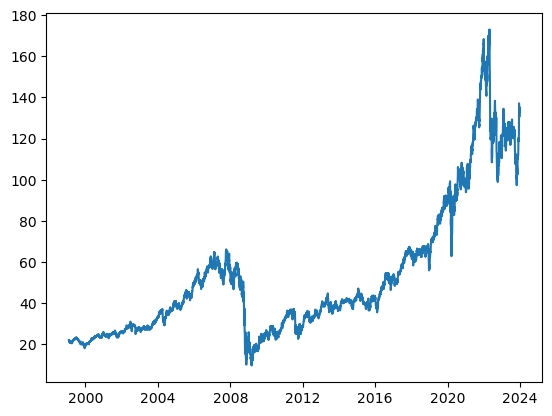

In [5]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'],data['Close'])

In [6]:
from copy import deepcopy as dc
def prepare_dataframe_for_lstm(df,n_steps):
    df = dc(df)
    df['Date'] = pd.to_datetime(df['Date'])
    
    df.set_index('Date',inplace=True)
    
    for i in range(1,n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data,lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2023-12-19,133.75,130.47,130.96,132.40,133.46,134.18,135.19,133.30
2023-12-18,132.68,133.75,130.47,130.96,132.40,133.46,134.18,135.19
2023-12-15,134.26,132.68,133.75,130.47,130.96,132.40,133.46,134.18
2023-12-14,137.12,134.26,132.68,133.75,130.47,130.96,132.40,133.46
2023-12-13,129.24,137.12,134.26,132.68,133.75,130.47,130.96,132.40
...,...,...,...,...,...,...,...,...
1999-02-05,21.81,21.81,21.88,21.06,21.06,20.94,21.00,20.88
1999-02-04,21.94,21.81,21.81,21.88,21.06,21.06,20.94,21.00
1999-02-03,22.00,21.94,21.81,21.81,21.88,21.06,21.06,20.94


In [7]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[133.75, 130.47, 130.96, ..., 134.18, 135.19, 133.3 ],
       [132.68, 133.75, 130.47, ..., 133.46, 134.18, 135.19],
       [134.26, 132.68, 133.75, ..., 132.4 , 133.46, 134.18],
       ...,
       [ 22.  ,  21.94,  21.81, ...,  21.06,  21.06,  20.94],
       [ 22.06,  22.  ,  21.94, ...,  21.88,  21.06,  21.06],
       [ 22.06,  22.06,  22.  , ...,  21.81,  21.88,  21.06]])

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[ 0.51913773,  0.47896381,  0.4849654 , ...,  0.52440443,
         0.53677506,  0.51362606],
       [ 0.50603221,  0.51913773,  0.47896381, ...,  0.51558577,
         0.52440443,  0.53677506],
       [ 0.52538429,  0.50603221,  0.51913773, ...,  0.50260273,
         0.51558577,  0.52440443],
       ...,
       [-0.84959275, -0.85032764, -0.8519199 , ..., -0.86110601,
        -0.86110601, -0.86257579],
       [-0.84885786, -0.84959275, -0.85032764, ..., -0.85106253,
        -0.86110601, -0.86110601],
       [-0.84885786, -0.84885786, -0.84959275, ..., -0.8519199 ,
        -0.85106253, -0.86110601]])

In [9]:
x = shifted_df_as_np[:,1:]
y = shifted_df_as_np[:,0]
x.shape, y.shape

((6263, 7), (6263,))

In [10]:
x = dc(np.flip(x,axis=1))
x

array([[ 0.51362606,  0.53677506,  0.52440443, ...,  0.50260273,
         0.4849654 ,  0.47896381],
       [ 0.53677506,  0.52440443,  0.51558577, ...,  0.4849654 ,
         0.47896381,  0.51913773],
       [ 0.52440443,  0.51558577,  0.50260273, ...,  0.47896381,
         0.51913773,  0.50603221],
       ...,
       [-0.86257579, -0.86110601, -0.86110601, ..., -0.8519199 ,
        -0.8519199 , -0.85032764],
       [-0.86110601, -0.86110601, -0.85106253, ..., -0.8519199 ,
        -0.85032764, -0.84959275],
       [-0.86110601, -0.85106253, -0.8519199 , ..., -0.85032764,
        -0.84959275, -0.84885786]])

In [11]:
split_index = int(len(x)*0.95)
split_index

5949

In [12]:
x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5949, 7), (314, 7), (5949,), (314,))

In [13]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([5949, 7]),
 torch.Size([314, 7]),
 torch.Size([5949]),
 torch.Size([314]))

In [14]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,i):
        return self.x[i], self.y[i]
    
train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)

In [15]:
train_dataset

In [16]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

In [17]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7]) torch.Size([16])


In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [19]:
from IPython.display import display

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        display(x_batch)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1


tensor([[-0.6793, -0.6789, -0.6811, -0.6855, -0.6901, -0.6943, -0.7040],
        [ 0.2039,  0.1883,  0.2105,  0.2374,  0.2647,  0.2406,  0.2267],
        [-0.5347, -0.5342, -0.5311, -0.5385, -0.5463, -0.5471, -0.5581],
        [-0.2177, -0.1942, -0.2218, -0.1347, -0.1039, -0.1494, -0.1675],
        [ 0.4787,  0.4597,  0.4692,  0.4543,  0.4492,  0.4474,  0.4442],
        [-0.6161, -0.6198, -0.6202, -0.6236, -0.6290, -0.6266, -0.6343],
        [ 0.1056,  0.1229,  0.1572,  0.1457,  0.1490,  0.1379,  0.1305],
        [-0.7726, -0.7732, -0.7718, -0.7773, -0.7761, -0.7778, -0.7772],
        [-0.7815, -0.7847, -0.7810, -0.7828, -0.7810, -0.7795, -0.7706],
        [-0.7463, -0.7517, -0.7441, -0.7452, -0.7479, -0.7418, -0.7492],
        [-0.3150, -0.3289, -0.3346, -0.3299, -0.3282, -0.3184, -0.3143],
        [-0.6849, -0.6800, -0.6846, -0.6889, -0.6893, -0.6977, -0.6929],
        [-0.4273, -0.4204, -0.4007, -0.4261, -0.4430, -0.4455, -0.4394],
        [-0.6770, -0.6815, -0.6803, -0.6831, -0.691

RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [ ]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [1]:
import pandas as pd
import datetime
import numpy
df = pd.read_csv('msft.csv')

In [2]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062311,308160000
1,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063386,133171200
2,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061774,67766400
3,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060700,47894400
4,1986-03-20,0.098090,0.098090,0.094618,0.095486,0.059089,58435200
...,...,...,...,...,...,...,...
9075,2022-03-16,289.109985,294.570007,283.200012,294.390015,289.156799,37826300
9076,2022-03-17,293.290009,295.609985,289.369995,295.220001,289.972046,30816600
9077,2022-03-18,295.369995,301.000000,292.730011,300.429993,295.089386,43390600
9078,2022-03-21,298.890015,300.140015,294.899994,299.160004,293.841949,28351200


In [3]:
df = df[['Date','Close']]

In [4]:
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [5]:
df['Date'] = df['Date'].apply(str_to_datetime)

/var/folders/f5/msl9m0cs5nxb47jjzhk83z0r0000gn/T/ipykernel_11844/3172778012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


In [6]:
df.index = df.pop('Date')

In [7]:
df

,Close
Date,
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
1986-03-20,0.095486
...,...
2022-03-16,294.390015
2022-03-17,295.220001
2022-03-18,300.429993


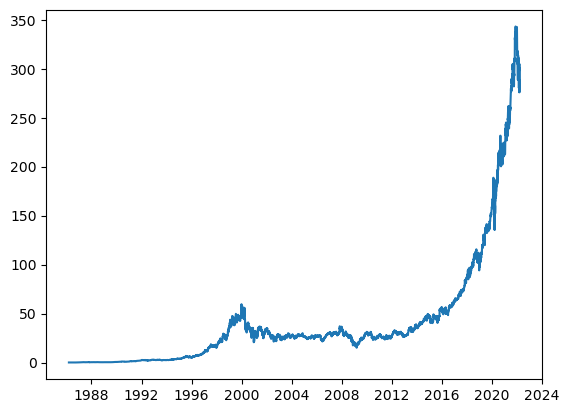

In [8]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['Close'])

In [16]:
dataframe=df
first_date_str='2021-03-21'
last_date_str
n=3

In [17]:
first_date = str_to_datetime(first_date_str)
last_date  = str_to_datetime(last_date_str)

target_date = first_date

dates = []
X, Y = [], []

last_time = False


KeyboardInterrupt



In [24]:
df_subset = dataframe.loc[:target_date].tail(3+1)

In [25]:
df_subset

,Close
Date,
2021-03-16,237.710007
2021-03-17,237.039993
2021-03-18,230.720001
2021-03-19,230.350006


In [10]:
target_date = str_to_datetime('2021-03-21')

In [11]:
df_subset = df.loc[:target_date].tail(3+1)
df_subset['Close'].to_numpy()

array([237.710007, 237.039993, 230.720001, 230.350006])

In [14]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)
    
    target_date = first_date
    
    dates = []
    X, Y = [], []
    
    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
    
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df


In [28]:
next_week = df.loc[target_date:target_date+datetime.timedelta(days=7)]


In [29]:
next_week

,Close
Date,
2021-03-22,235.990005
2021-03-23,237.580002
2021-03-24,235.460007
2021-03-25,232.339996
2021-03-26,236.479996


In [15]:
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-21', 
                                '2022-03-19', 
                                n=3)
windowed_df

KeyboardInterrupt: 

In [ ]:
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y



In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)



In [ ]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape